# Neighborhoods question
Q (from a meeting agenda Bloomberg_ Gun Violence Dashboard_ Meeting 2 Agenda.docx): 
```
Final Neighborhood Questions:
1. Not duplicating MSU Project Green Light (PGL) study, what new can we learn from PGL data that give insight to where interventions should be targeted?
2. Are there specific locations/ property types that become magnets for gun violence incidents?
3. What can we find unique to areas/ blocks where we see highest event rates (presence of empty lots, convenience stores, gas stations, bus stops, schools, etc)?
```

If we're looking to identify where interventions should be targeted... Detroit has the gun violence rates, so the clearly correct thing to do is target interventions where gun violence rates are high.

Another way of viewing this question is to inform policy choices (change characteristics based on correlations and hope it's causal). This would require _way_ more work than we have time for

In [1]:
import geopandas as gpd

from features.income import Income
from features.violence_calls import ViolenceCalls
from features.households import Households
from features.household_types_ages import HouseholdTypesAges
from features.household_types import HouseholdTypes
from features.population import Population
from features.population_density import PopulationDensity
from features.feature_constructor import Feature
from features.out_of_state_rental_ownership import OutOfStateRentalOwnership
from features.ddot_bus_stops import DDotBusStops
from features.smart_bus_stops import SmartBusStops
from features.rental_statuses import RentalStatuses
from features.project_green_light_locations import ProjectGreenlightLocations
from features.liquor_licenses import LiquorLicenses
from features.vacant_property_registrations import VacantPropertyRegistrations

from util_detroit import concatenate_features, point_to_geo_id

from detroit_geos import get_detroit_census_geos, get_detroit_boundaries

import patsy
from patsy import dmatrices, dmatrix
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.impute import SimpleImputer
import matplotlib as mpl

In [ ]:
# Fetch geometries for visualization

tracts = get_detroit_census_geos(decennial_census_year=2010,target_geo_grain='tract',).set_index('geo_id')
detroit = get_detroit_boundaries()
block = get_detroit_census_geos(decennial_census_year=2010,target_geo_grain='block').set_index('geo_id')

# Build Features

In [5]:
target_geo_grain = "tract"
feature_objects = [
    Population(
        decennial_census_year=2010, population_data_path="population", verbose=False
    ),
    PopulationDensity(
        decennial_census_year=2010,
        population_data_path="population",
    ),
    ViolenceCalls(decennial_census_year=2010, verbose=False),
    Income(verbose=False),
    Households(),
    OutOfStateRentalOwnership(2010),
    DDotBusStops(decennial_census_year=2010),
    SmartBusStops(decennial_census_year=2010),
    RentalStatuses(decennial_census_year=2010),
    ProjectGreenlightLocations(decennial_census_year=2010),
    LiquorLicenses(decennial_census_year=2010),
    VacantPropertyRegistrations(decennial_census_year=2010)
    
]
feat_df = concatenate_features(feature_objects,'tract')

# Transform

In [6]:
from munge_features import transform_1
from constants import COLNAME_MAP
from sklearn.preprocessing import StandardScaler
df, df0 = transform_1(feat_df)
# df = df.assign(liquor_license_density = df0.liquor_license_density)

# df = pd.DataFrame(StandardScaler().fit_transform(df),index=df.index,columns=df.columns)

# fig, ax = plt.subplots(1,1,figsize=(20,20))
# df.hist(ax=ax,bins=20)

[Text(0.5, 0, 'Bus stops per km$^2$'), Text(0, 0.5, 'Number of census tracts')]

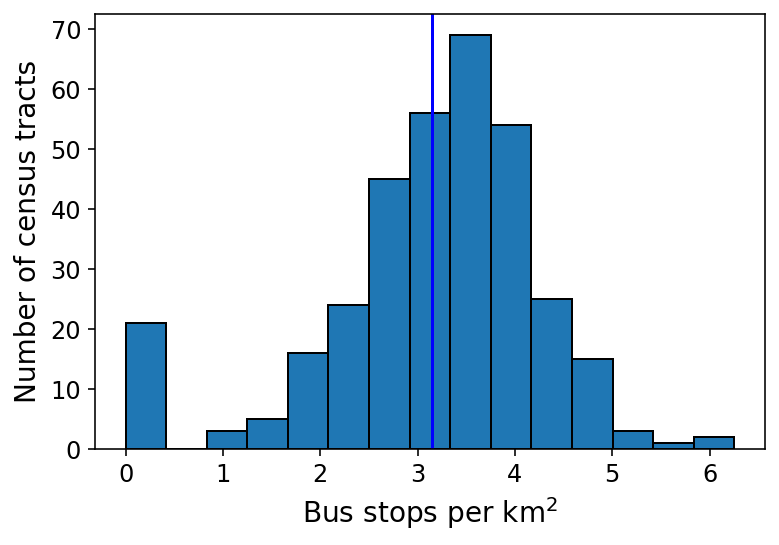

In [9]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
df.bus_density.hist(edgecolor='k',bins=15,ax=ax)
ax.axvline(x=df.bus_density.mean(),color='b')
ax.grid(False)
ax.set(xlabel='Bus stops per km$^2$',ylabel='Number of census tracts')

# Run regressions

In [10]:
formula_bones = "call_rate ~ " + '\n+ '.join([x for x in df.columns if ('call_rate' not in x)])
formula = formula_bones#.replace('per_household_income','np.log(per_household_income)')
y, X = dmatrices(
    formula_like=formula,
    data=df,
    return_type="dataframe",
)
# D = dmatrix(
#     formula_like=formula.replace('~','+'),
#     data=df,
#     return_type="dataframe",
# )

# r2 = (D.corr()**2).call_rate.sort_values()

In [11]:
# no regularization
XX = patsy.standardize(X).assign(Intercept=1).astype(float)
mdl = sm.OLS(endog=y,exog=XX)
res = mdl.fit()
# res.summary()

# res.params

<AxesSubplot:xlabel='log of household income', ylabel='annual gun-violence 911 calls/capita'>

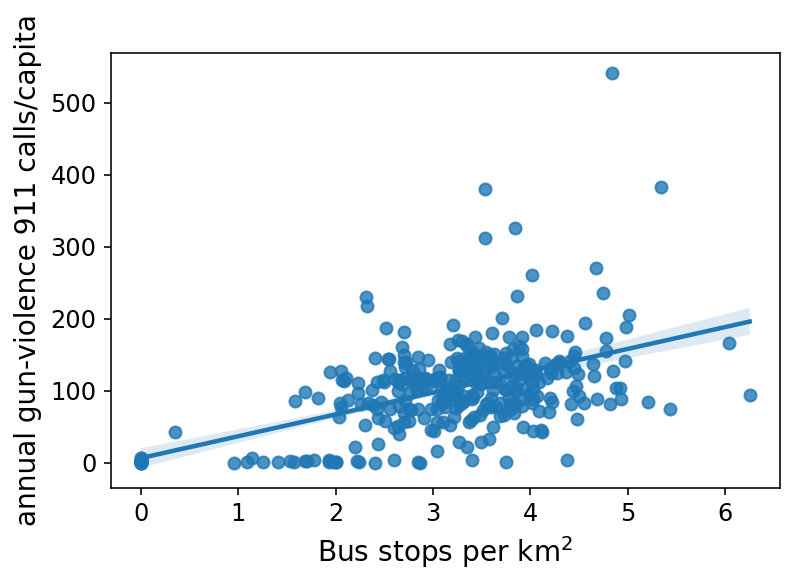

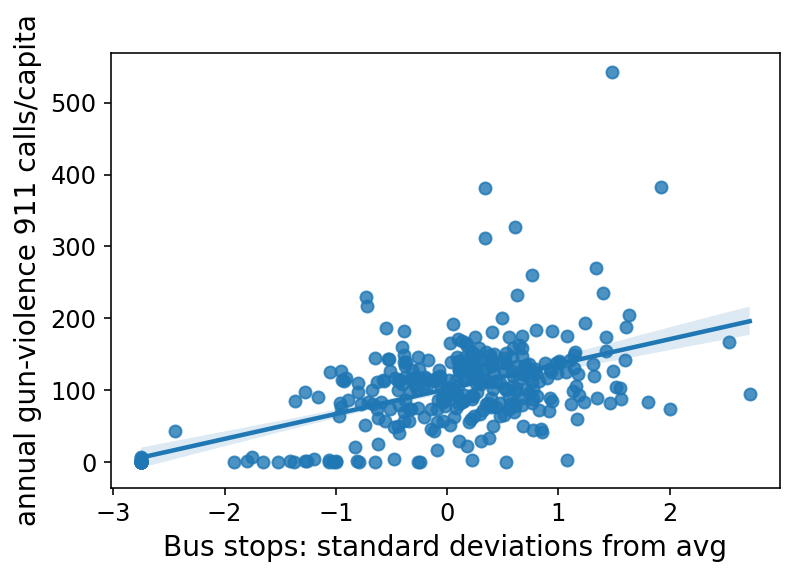

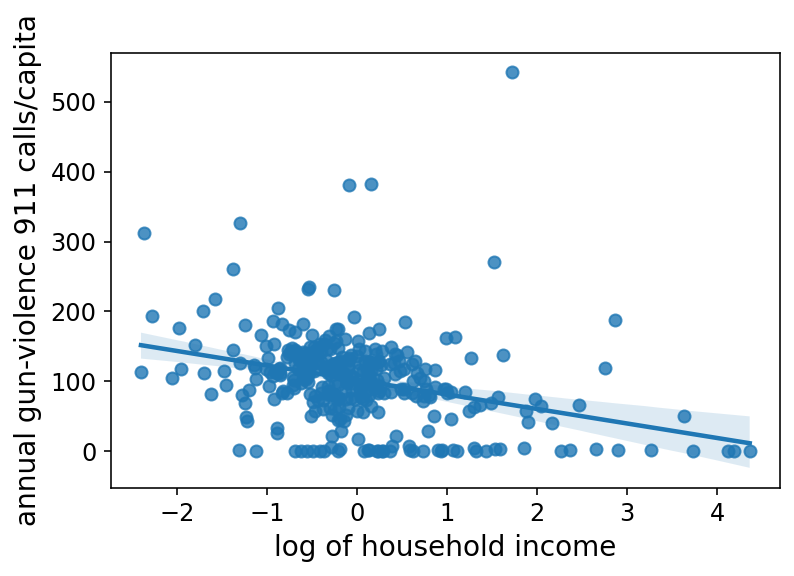

In [12]:
def do_regplot(df,xcol='bus_density',xlabel='Bus stops per km$^2$',ylim=[0,400]):
    fig, ax = plt.subplots(1,1,figsize=(6,4))
    sns.regplot(x=xcol,y='call_rate',data=df,ax=ax)
    # sns.regplot(x='bus_density',y='call_rate',data=(df,ax=ax)
#     ax.set_ylim(ylim)
    ax.set(xlabel=xlabel, ylabel='annual gun-violence 911 calls/capita')
    return ax
ax = do_regplot(df)
ax = do_regplot(pd.concat((y,XX),axis=1),xlabel='Bus stops: standard deviations from avg')

do_regplot(pd.concat((y,XX),axis=1),xcol='per_household_income',xlabel='log of household income')

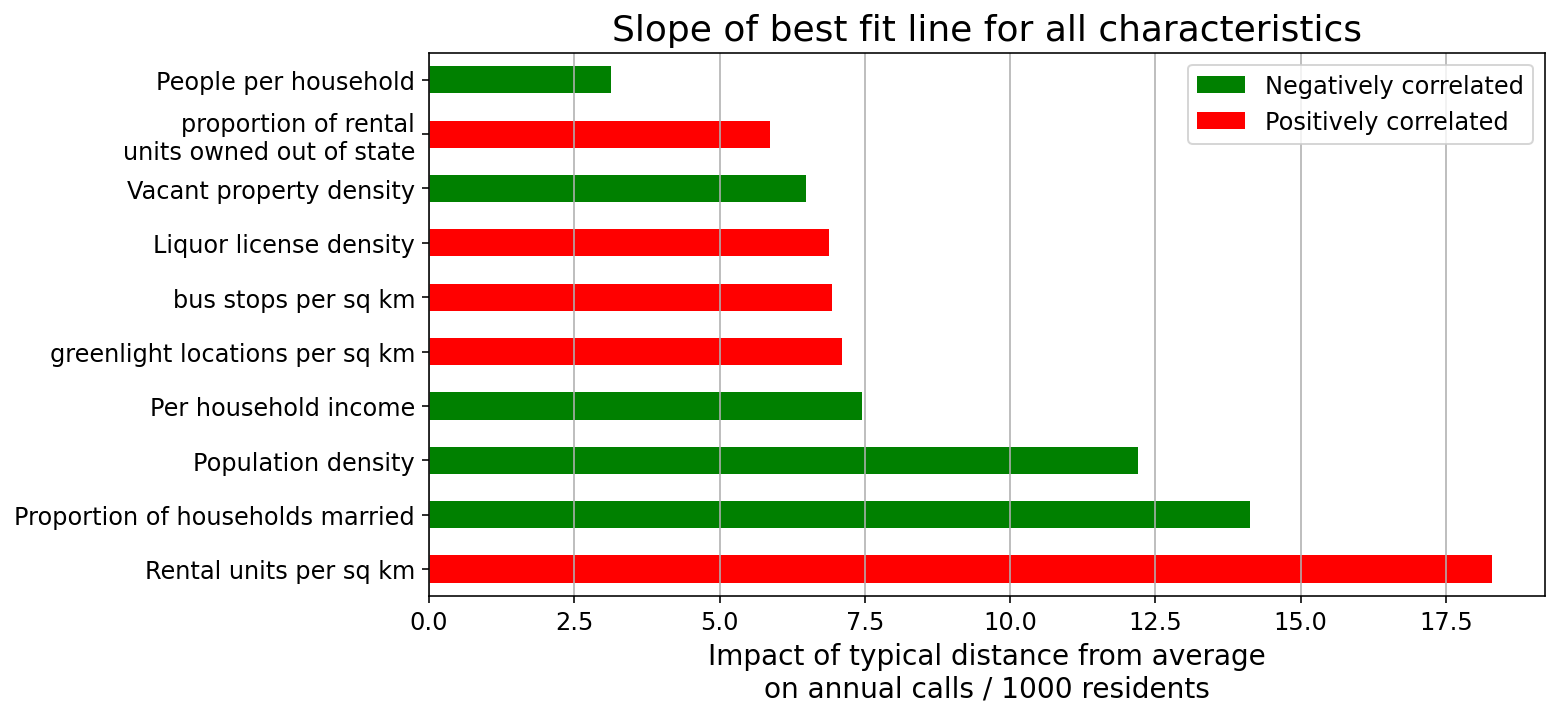

In [18]:
from constants import COLNAME_MAP
fig, ax = plt.subplots(1,1,figsize=(10,5))
sorted_abs_params = res.params.drop('Intercept').abs().sort_values(ascending=False)

tt = sorted_abs_params.rename(COLNAME_MAP).plot(kind='barh',ax=ax,color=['r' if x else 'g' for x in (res.params.loc[sorted_abs_params.index]>0)])
ax.grid(True, axis='x')
_ = ax.set(xlabel='Impact of typical distance from average\non annual calls / 1000 residents',title='Slope of best fit line for all characteristics')
rects =[c for c in tt.get_children() if isinstance(c,mpl.patches.Rectangle)] 
ax.legend([[x for x in rects if x.get_facecolor()==(0.0, 0.5, 0.0, 1.0)][0]]+[[x for x in rects if x.get_facecolor()==(1.0, 0.0, 0.0, 1.0)][0]],['Negatively correlated','Positively correlated'])

In [778]:
# # lasso
# XX = patsy.standardize(X).assign(Intercept=1).astype(float)
# mdl = sm.OLS(endog=y,exog=XX)
# res = mdl.fit_regularized(method='elastic_net',L1_wt = 1,alpha=5,refit=False,zero_tol=.0001)
# XXX = XX.drop(columns=res.params[res.params==0].index)
# mdl = sm.OLS(endog=y,exog=XXX)

# res = mdl.fit()
# res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              call_rate   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     51.53
Date:                Thu, 17 Mar 2022   Prob (F-statistic):           1.18e-44
Time:                        16:24:35   Log-Likelihood:                -1780.8
No. Observations:                 339   AIC:                             3576.
Df Residuals:                     332   BIC:                             3602.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                101.7801      2.539     40.088      0.000      96.786     106.775
population_density       -10.3635      2.887     -3.590      0.000     -16.042      -4.685
married_household_prop   -18.7610      2.924     -6.417      0.000     -24.512     -13.010
greenlight_density         6.0679      3.402      1.784      0.075      -0.624      12.760
rental_density            17.7549      4.039      4.396      0.000       9.810      25.700
bus_density                7.1936      3.999      1.799      0.073      -0.673      15.061
liquor_license_density     5.5090      3.635      1.515      0.131      -1.642      12.660
==============================================================================
Omnibus:                      253.011   Durbin-Watson:                   1.827
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4558.344
Skew:                           2.905   Prob(JB):                         0.00
Kurtosis:                      19.999   Cond. No.                         3.51
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
# with lasso
df, df0 = transform_1(feat_df)
# df = df.assign(liquor_license_density = pd.qcut(df0.liquor_license_density,3, ))

formula_bones = "call_rate ~ " + '\n+ '.join([x for x in df.columns if ('call_rate' not in x)])
formula = formula_bones
y, X = dmatrices(
    formula_like=formula,
    data=df,
    return_type="dataframe",
)
cols_to_standardize = [x for x in df.columns if (x not in ('Intercept','call_rate')) and (df.dtypes[x].name != 'category')]
XX = X.copy()

XX.loc[:,cols_to_standardize] = patsy.standardize(X.loc[:,cols_to_standardize])
mdl = sm.OLS(endog=y,exog=XX)
res_reg = mdl.fit_regularized(method='elastic_net',L1_wt = 1,alpha=5,refit=False,zero_tol=.0001)
XXX = XX.drop(columns=res_reg.params[res_reg.params==0].index)
mdl = sm.OLS(endog=y,exog=XXX)

res = mdl.fit()
res.summary()

# print(res_reg.params)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              call_rate   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     51.53
Date:                Thu, 17 Mar 2022   Prob (F-statistic):           1.18e-44
Time:                        17:27:38   Log-Likelihood:                -1780.8
No. Observations:                 339   AIC:                             3576.
Df Residuals:                     332   BIC:                             3602.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                101.7801      2.539     40.088      0.000      96.786     106.775
population_density       -10.3635      2.887     -3.590      0.000     -16.042      -4.685
married_household_prop   -18.7610      2.924     -6.417      0.000     -24.512     -13.010
greenlight_density         6.0679      3.402      1.784      0.075      -0.624      12.760
rental_density            17.7549      4.039      4.396      0.000       9.810      25.700
bus_density                7.1936      3.999      1.799      0.073      -0.673      15.061
liquor_license_density     5.5090      3.635      1.515      0.131      -1.642      12.660
==============================================================================
Omnibus:                      253.011   Durbin-Watson:                   1.827
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4558.344
Skew:                           2.905   Prob(JB):                         0.00
Kurtosis:                      19.999   Cond. No.                         3.51
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

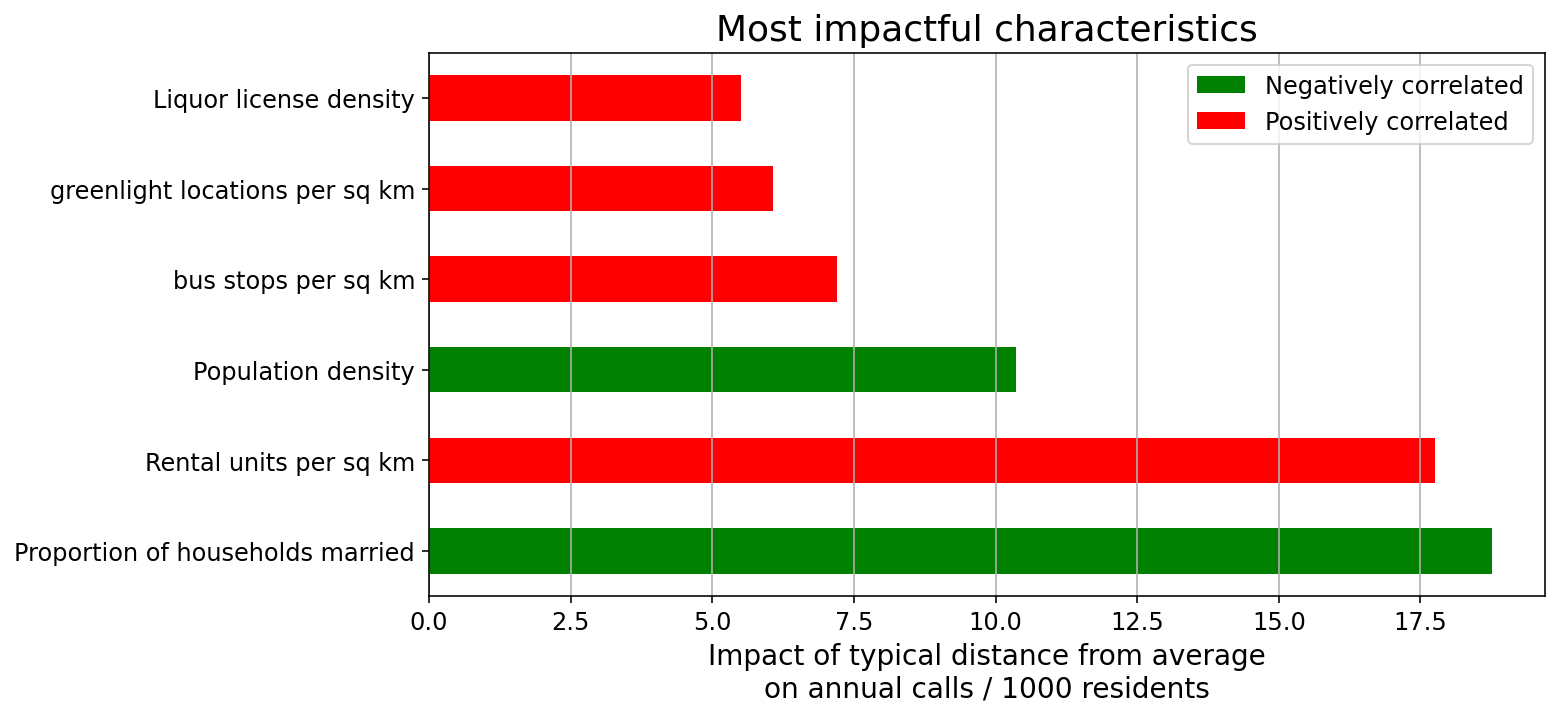

In [20]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
sorted_abs_params = res.params.drop('Intercept').abs().sort_values(ascending=False)

tt = sorted_abs_params.rename(COLNAME_MAP).plot(kind='barh',ax=ax,color=['r' if x else 'g' for x in (res.params.loc[sorted_abs_params.index]>0)])
ax.grid(True, axis='x')
_ = ax.set(xlabel='Impact of typical distance from average\non annual calls / 1000 residents',title='Most impactful characteristics')
rects =[c for c in tt.get_children() if isinstance(c,mpl.patches.Rectangle)] 
ax.legend([[x for x in rects if x.get_facecolor()==(0.0, 0.5, 0.0, 1.0)][0]]+[[x for x in rects if x.get_facecolor()==(1.0, 0.0, 0.0, 1.0)][0]],['Negatively correlated','Positively correlated'])

In [21]:
most_calls = y.sort_values('call_rate').index[-5:]
XXX.loc[most_calls]

,Intercept,population_density,married_household_prop,greenlight_density,rental_density,bus_density,liquor_license_density
tract,,,,,,,
2.616352e+10,1.0,-1.048120,-1.249835,-0.218211,0.026174,0.342902,-0.200872
2.616355e+10,1.0,-1.667417,-0.660611,-0.023452,1.182370,0.605981,-1.423332
2.616350e+10,1.0,-0.597832,0.192059,-1.171156,0.727940,0.343130,0.600825
2.616399e+10,1.0,-2.209308,-0.450519,0.567416,-0.647011,1.926068,0.878592
2.616352e+10,1.0,-1.555286,-0.790638,3.190461,-0.615081,1.483208,3.616207


In [23]:
contributions = (XXX.loc[most_calls]*res.params)#.drop(columns=['Intercept'])
contributions

,Intercept,population_density,married_household_prop,greenlight_density,rental_density,bus_density,liquor_license_density
tract,,,,,,,
2.616352e+10,101.78015,10.862158,23.448123,-1.324094,0.464709,2.466708,-1.106603
2.616355e+10,101.78015,17.280227,12.393708,-0.142306,20.992889,4.359198,-7.841137
2.616350e+10,101.78015,6.195614,-3.603208,-7.106513,12.924510,2.468345,3.309944
2.616399e+10,101.78015,22.896103,8.452168,3.443049,-11.487635,13.855404,4.840167
2.616352e+10,101.78015,16.118160,14.833146,19.359545,-10.920720,10.669638,19.921694


In [24]:
contributions.assign(call_rate=y,error=lambda x: x.sum(axis=1)-2*x.call_rate)

,Intercept,population_density,married_household_prop,greenlight_density,rental_density,bus_density,liquor_license_density,call_rate,error
tract,,,,,,,,,
2.616352e+10,101.78015,10.862158,23.448123,-1.324094,0.464709,2.466708,-1.106603,311.924828,-175.333677
2.616355e+10,101.78015,17.280227,12.393708,-0.142306,20.992889,4.359198,-7.841137,326.590443,-177.767715
2.616350e+10,101.78015,6.195614,-3.603208,-7.106513,12.924510,2.468345,3.309944,380.682134,-264.713293
2.616399e+10,101.78015,22.896103,8.452168,3.443049,-11.487635,13.855404,4.840167,383.017164,-239.237759
2.616352e+10,101.78015,16.118160,14.833146,19.359545,-10.920720,10.669638,19.921694,541.956421,-370.194809


In [33]:
import plotly.graph_objects as go
contributions_no_int = contributions.drop(columns=['Intercept']).assign(t=lambda x: x.sum(axis=1)).rename(columns={'t':'Total expected difference from avg'})
# fig, ax = plt.subplots(1,1,figsize=(6,4))
for i in range(contributions.shape[0]):
    s = contributions_no_int.iloc[i, :]
    fig = go.Figure(
        go.Waterfall(
            name="Annual calls per 1k residents",
            orientation="v",
            measure =  (len(s)-1)*['relative']+['total'],
            x=contributions_no_int.rename(columns=COLNAME_MAP).columns,
            textposition="outside",
            #     text = ["+60", "+80", "", "-40", "-20", "Total"],
            y=s.values,
            connector={"line": {"color": "rgb(63, 63, 63)"}},
            decreasing = {"marker":{"color":"green"}},
            increasing = {"marker":{"color":"red"}},
            totals = {"marker":{"color":"deep sky blue", "line":{"color":"black", "width":2}}}
            #         ax=ax
        )
    )

    fig.update_layout(
        font=dict(size=20),
        yaxis_title="Impact on annual calls per capita",
        title=f"Contributors for tract {int(most_calls[i])}",
        showlegend=False,
        height=800
    )
#     fig.show()
    fig.write_image(f"images/fig{i}.png")

# plt.gca().set(ylabel='Associated Impact on annual violent events per capita')

Text(1189.4050000000002, 0.5, 'Annual calls per 1k residents')

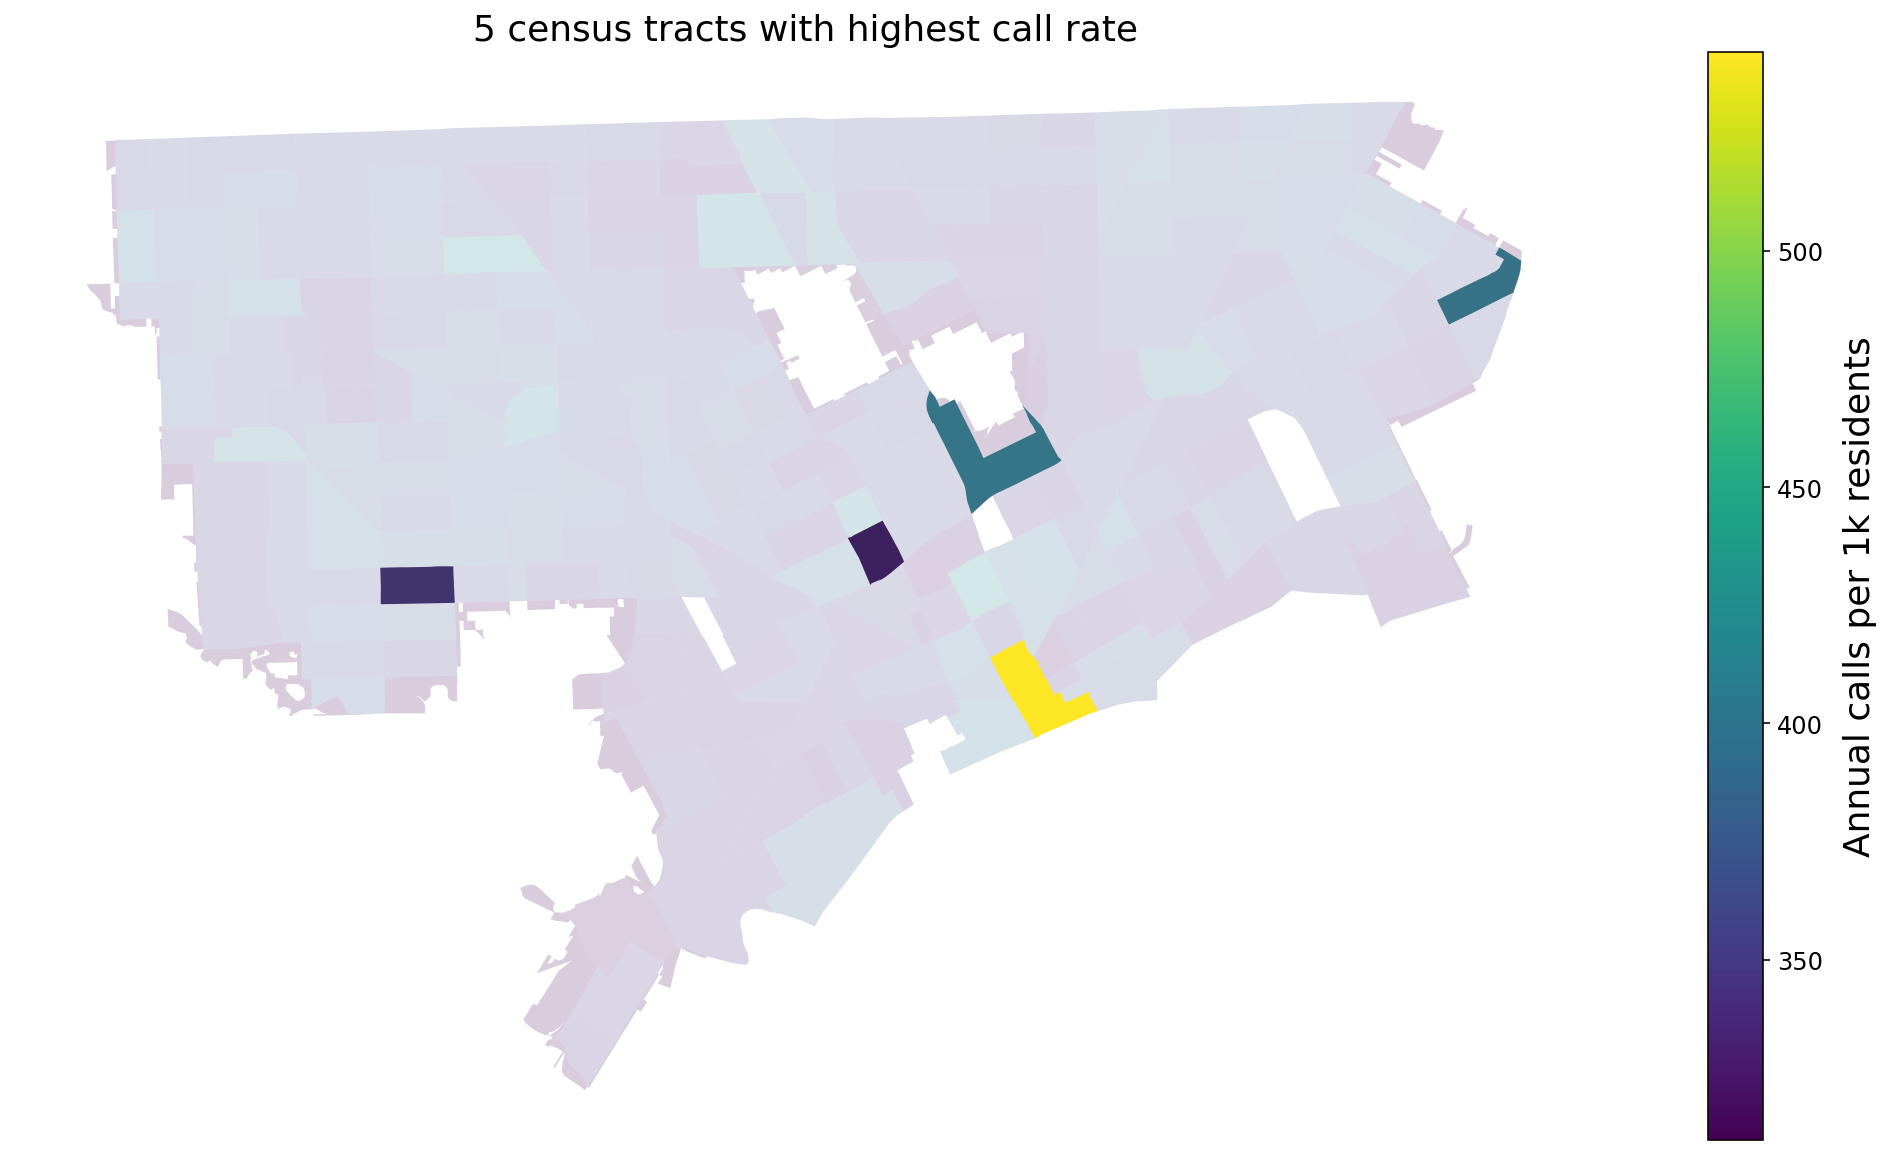

In [821]:
from detroit_geos import nice_detroit_plot
fig, ax= plt.subplots(1,1,figsize=(20,10))
nice_detroit_plot(pd.concat((tracts,df),axis=1).loc[most_calls,:],color_column='call_rate',polygons_df=tracts,ax=ax,alpha=1)
ax = nice_detroit_plot(pd.concat((tracts,df),axis=1),color_column='call_rate',polygons_df=tracts,ax=ax,legend=False,alpha=0.2)
ax.set(title='5 census tracts with highest call rate')
[x for x in fig.get_children() if x.get_label() == '<colorbar>'][0].set_ylabel('Annual calls per 1k residents',font={'size':18},labelpad=10)

In [840]:
XXX.loc[most_calls]

,Intercept,population_density,married_household_prop,greenlight_density,rental_density,bus_density,liquor_license_density
tract,,,,,,,
2.616352e+10,1.0,-1.048120,-1.249835,-0.218211,0.026174,0.342902,-0.200872
2.616355e+10,1.0,-1.667417,-0.660611,-0.023452,1.182370,0.605981,-1.423332
2.616350e+10,1.0,-0.597832,0.192059,-1.171156,0.727940,0.343130,0.600825
2.616399e+10,1.0,-2.209308,-0.450519,0.567416,-0.647011,1.926068,0.878592
2.616352e+10,1.0,-1.555286,-0.790638,3.190461,-0.615081,1.483208,3.616207


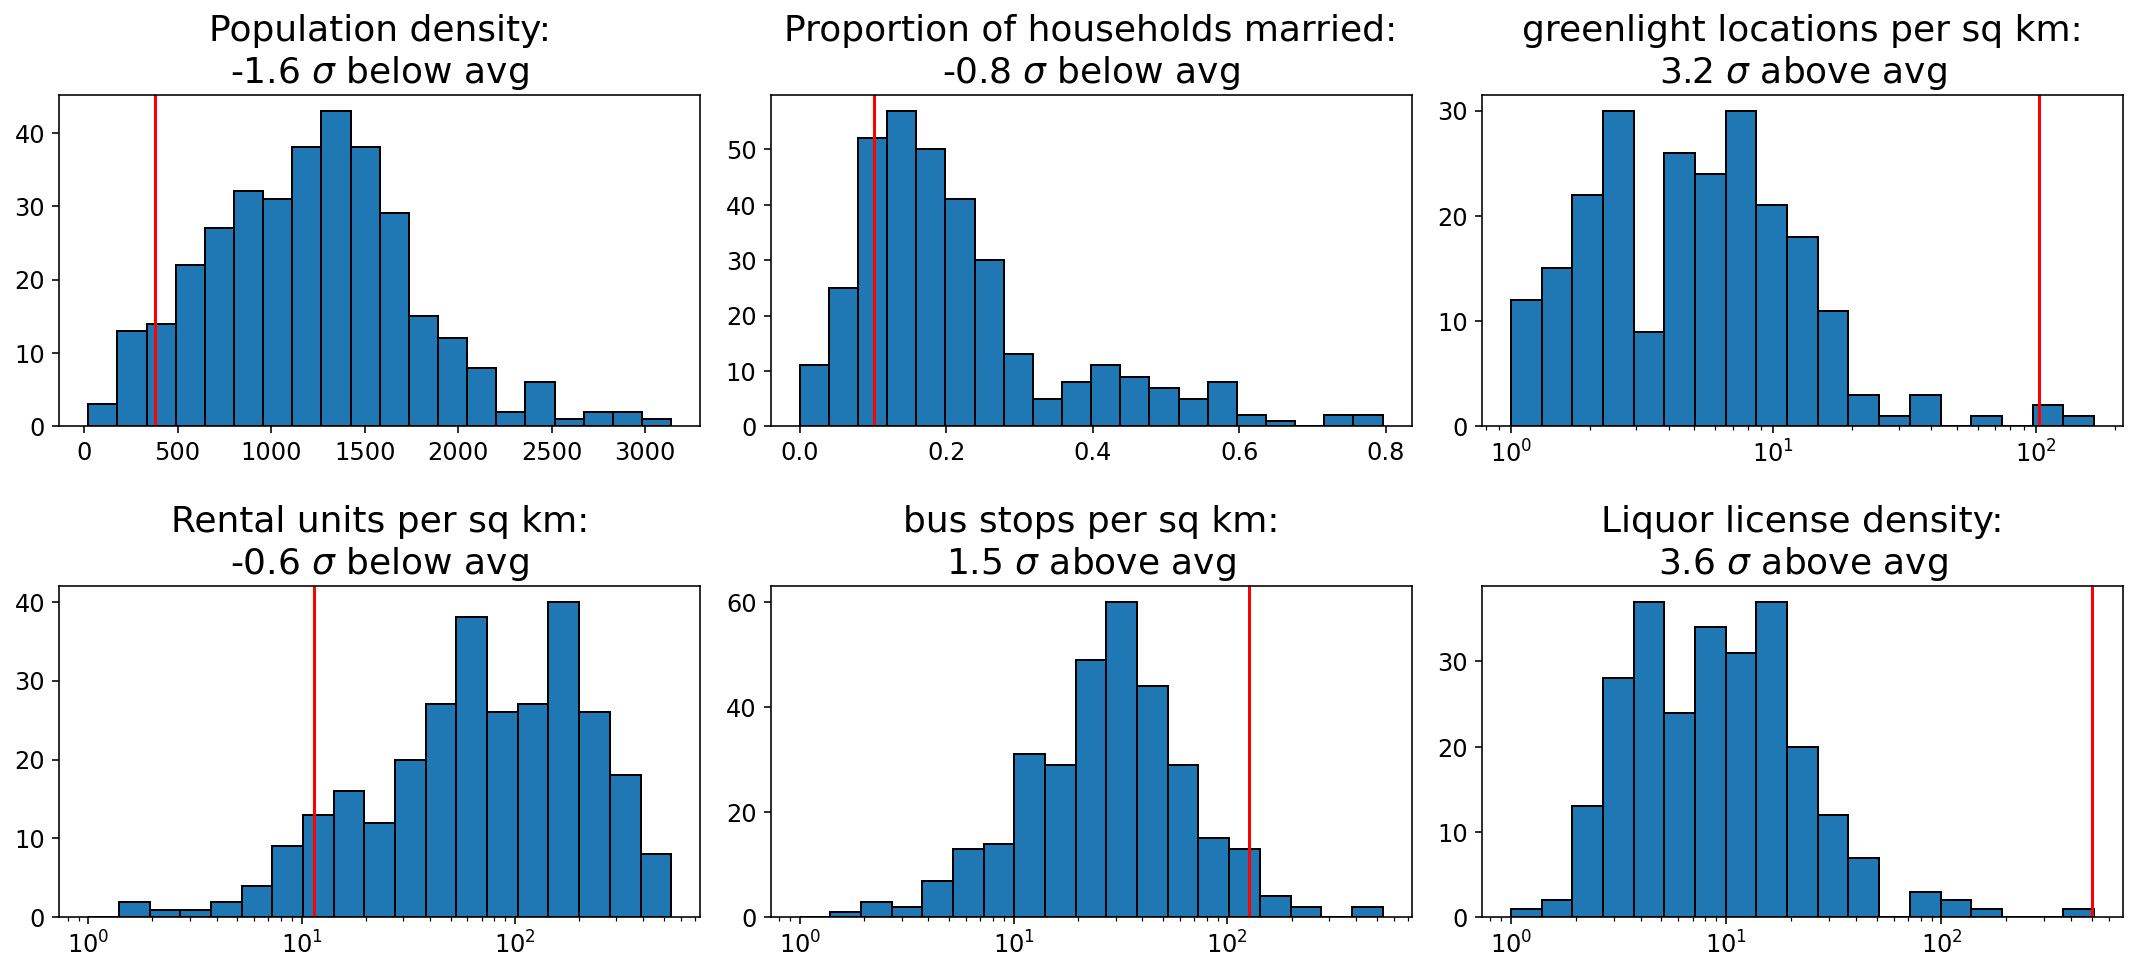

In [846]:
from constants import COLNAME_MAP
cols_to_log=["greenlight_density", "rental_density", "bus_density", "per_household_income","liquor_license_density"]
stds = XXX.loc[most_calls]
for tract in most_calls[-1:]:
    cols = res.params.drop('Intercept').index
    df0_slim = df0.copy().loc[:,cols]
    fig, ax = plt.subplots(2,int(len(cols)/2),figsize=(2.5*len(cols),7))
    ax = ax.ravel()
    for i, c in enumerate(cols):
        if c in cols_to_log:
            bins = np.geomspace(df0_slim.loc[:,c].min()+1,df0_slim.loc[:,c].max()+12,num=20)
            ax[i].set(xscale='log')
        else:
            bins = 20
        ax[i].hist(df0_slim.loc[:,c],bins=bins,edgecolor='k')
        score = stds.loc[tract,c]
        ax[i].set(title=COLNAME_MAP[c]+ f':\n{score:.1f} $\sigma$ {"above" if score > 0 else "below"} avg')
        ax[i].axvline(x=df0_slim.loc[tract,c],color='r')
    plt.tight_layout()

    


In [837]:
most_calls[-1]

26163517200.0

In [46]:
# formula = (
#     formula_bones.replace("per_household_income", "np.log(per_household_income)")
#     .replace("rental_density", "np.log(rental_density+1)")
#     .replace("bus_density", "np.log(bus_density+1)")
# )
formula = formula_bones

y, X = dmatrices(
    formula_like=formula,
    data=df,
    return_type="dataframe",
)

mdl = sm.OLS(endog=y, exog=X)
res = mdl.fit()
res.summary()

# fig, ax = plt.subplots(1, 1, figsize=(20, 20))
# X.hist(ax=ax)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              call_rate   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     17.76
Date:                Tue, 15 Mar 2022   Prob (F-statistic):           4.60e-22
Time:                        14:41:00   Log-Likelihood:                -423.12
No. Observations:                 341   AIC:                             864.2
Df Residuals:                     332   BIC:                             898.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                      1.691e-17      0.046   3.68e-16      1.000      -0.090       0.090
population_density               -0.2029      0.054     -3.746      0.000      -0.309      -0.096
per_household_income             -0.0506      0.063     -0.799      0.425      -0.175       0.074
out_of_state_rental_ownership     0.0877      0.048      1.824      0.069      -0.007       0.182
married_household_prop           -0.2388      0.066     -3.628      0.000      -0.368      -0.109
greenlight_density                0.0989      0.058      1.693      0.091      -0.016       0.214
people_per_household              0.0277      0.052      0.533      0.594      -0.075       0.130
rental_density                    0.1203      0.074      1.615      0.107      -0.026       0.267
bus_density                       0.1402      0.070      1.992      0.047       0.002       0.279
==============================================================================
Omnibus:                      517.946   Durbin-Watson:                   1.666
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           127236.242
Skew:                           7.738   Prob(JB):                         0.00
Kurtosis:                      96.357   Cond. No.                         3.46
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
y, X = dmatrices(
    formula_like=formula,
    data=df,
    return_type="dataframe",
)
# exposure = X.pop('population')
mdl = sm.GLM(endog=y,exog=X,family=sm.families.Poisson())
res = mdl.fit()

res.summary()
res = mdl.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              call_rate   No. Observations:                  341
Model:                            GLM   Df Residuals:                      332
Model Family:                 Poisson   Df Model:                            8
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -242.69
Date:                Tue, 08 Mar 2022   Deviance:                       52.806
Time:                        16:36:22   Pearson chi2:                     60.9
No. Iterations:                     5   Pseudo R-squ. (CS):            0.08364
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.4649      3.308      0.141      0.888      -6.018       6.948
population_density               -0.0003      0.000     -1.761      0.078      -0.001    3.59e-05
np.log(per_household_income)     -0.0715      0.311     -0.230      0.818      -0.682       0.539
out_of_state_rental_ownership     0.7246      0.596      1.216      0.224      -0.444       1.893
married_household_prop           -2.8160      0.945     -2.981      0.003      -4.667      -0.965
rental_density                    0.0010      0.001      1.292      0.196      -0.001       0.002
bus_density                      -0.0002      0.002     -0.116      0.907      -0.003       0.003
greenlight_density                0.0053      0.005      1.153      0.249      -0.004       0.014
people_per_household              0.0515      0.106      0.488      0.626      -0.155       0.258
=================================================================================================
"""

# Compare impact of granularity

In [13]:
mdl = {}
res = {}
for target_geo_grain in ("block","block group","tract"):
    feat_df = concatenate_features(feature_objects,target_geo_grain)
    df = transform_1(feat_df)
    y, X = dmatrices(
        formula_like=formula,
        data=df,
        return_type="dataframe",
    )
    mdl[target_geo_grain] = sm.OLS(endog=y,exog=X)
    res[target_geo_grain] = mdl[target_geo_grain].fit()
    res[target_geo_grain].summary()

You may want to rerun self.cache_features()
You may want to rerun self.cache_features()
You may want to rerun self.cache_features()


In [14]:
res['block group'].conf_int()

,0,1
Intercept,0.967753,2.730049
population_density,-0.000125,-0.000046
np.log(per_household_income),-0.196128,-0.028101
out_of_state_rental_ownership,0.097762,0.352427
married_household_prop,-0.838216,-0.411278
rental_density,-0.000583,0.001865
bus_density,0.000696,0.004982
greenlight_density,0.018573,0.034731
people_per_household,-0.074605,0.004508


In [46]:
l = [pd.concat((res[g].conf_int().rename(columns={0:.025,1:.975}),res[g].params.rename(0.5)),axis=1) for g in ("block","block group","tract")]

grains = ("block","block group","tract")

tt = pd.concat(l,keys=grains).loc[:,[.025,.500,.975]].assign(y=np.nan)

for i, g in enumerate(grains):
    tt.loc[g,'y'] = np.zeros(tt.loc[g,'y'].shape[0])+.2*i

fig, ax = plt.subplots(9,1,figsize=(8,30))
for _, sub_df in tt.groupby(level=0):
    i = 0
    for name, sdf in sub_df.reset_index(level=1).melt(id_vars=['y','level_1']).sort_values(['level_1','y']).groupby('level_1'):
        sdf.plot(x='value',y='y',ax=ax[i],marker='o',legend=False,title=name)
        ax[i].legend(grains)
        i+=1
plt.tight_layout()